# Welds classifier

Absolutely all welds in production must be visually inspected during quality control, this is a mandatory requirement of the regulatory authorities. This task is performed by experienced specialists and their classification accuracy is close to 95%. However, in a large production plant, the number of seams produced per day can be measured in thousands. Manual visual inspection can be very time-consuming for highly skilled technicians. To optimize their time, I have to write a program that can classify defective and quality welds from the weld image. In addition, it is important for production to classify defective welds according to the type of defect in order to set up welding machines correctly. Images of the welds are taken during welding, 2 frames per second. The main requirement for the model is to minimize the errors of the first kind (the model recognizes the defective weld as a quality weld), and the prediction speed should be faster than 0.5 seconds. Then, it will be possible to get the value of frames, which the model should get for each seam, in order to nullify the error of the first kind. 

## STEP 1. Import data and libraries 

In [1]:
import numpy as np
import pandas as pd
import zipfile
from matplotlib import pyplot as plt
%matplotlib inline
import shutil 
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models
import os
import torch.nn as nn
from PIL import Image
with zipfile.ZipFile(r"data\welds.zip",'r') as zip_obj:
        zip_obj.extractall(r"data\data_root")
data_root = r"data\data_root\al5083"
print('Success!')

Success!


## STEP 2. Data markup

I have a json file with markup. I need to parse it. I am adding a column for a binary classification

In [2]:
js = os.path.join(data_root, r"train\train.json")
labels = pd.read_json(js, typ='series')
labels = labels.to_frame().reset_index().rename(columns={'index':'path',0:'class'})
def create_binary_label(row):
    if row['class'] == 0:
        return 'good_weld'
    else:
        return 'bad_weld'
labels['binary'] = labels.apply(create_binary_label, axis=1)
labels = labels.sort_values(by='binary').reset_index().drop(['index','class'],axis=1)
classes = labels['binary'].unique()
labels.binary.describe()

count        26666
unique           2
top       bad_weld
freq         17908
Name: binary, dtype: object

To improve the accuracy of the model it was decided to create two neural networks - the first one will binary classify good and bad seams, and the second one will determine the type of defect in bad seams. To balance the data in the binary classification it is necessary to double the number of good seams due to augmentation.

# STEP 3. Data balancing

If data balancing is not applied, there will be twice as many bad examples as good examples. This may affect the accuracy of the model, because the model will be biased in favor of the bad class and will predict it more often than the good class. In this case, I believe it is correct to perform data balancing by oversampling, i.e. increasing the number of images of a smaller class. The class ratio now is about 33% - 67%, so for balancing we need to double the number of good images. Let's look at an example of a good image.

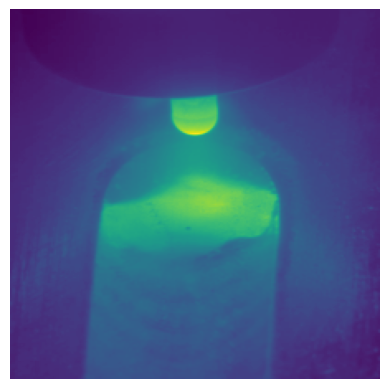

In [3]:
binary_train = 'data/binary_train'
train_dir = os.path.join(binary_train,'train')
val_dir = os.path.join(binary_train,'val')
for class_name in classes:
    os.makedirs(os.path.join(binary_train, class_name), exist_ok=True)

for class_name in classes: 
    for i, file_name in enumerate(tqdm(labels['path'].loc[labels['binary']==class_name].tolist())):
        pic_name = str(class_name) + "_" + str(i) + '.jpg'
        shutil.copy(os.path.join(data_root, 'train', file_name), os.path.join(os.path.join(binary_train, class_name, pic_name)))
files = os.listdir(os.path.join(binary_train,'good_weld'))
image_path = os.path.join('data/binary_train/good_weld', files[0])
image = Image.open(image_path)
resized_image = image.resize((224, 224))
plt.imshow(resized_image)
plt.axis('off')  
plt.show()

Obviously, if you mirror a seam - it will still be classifiable by a human, but it will be a new image for the model. So I want to apply mirroring to all good seams.

In [4]:
directory = 'data/binary_train/good_weld'
files = os.listdir(directory)
for filename in files:
    if filename.endswith('.jpg'):
        file_path = os.path.join(directory, filename)
        image = Image.open(file_path)
        mirrored_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        new_filename = 'mirrored_' + filename
        new_file_path = os.path.join(directory, new_filename)
        mirrored_image.save(new_file_path)
        image.close()
print('Success')

Success


## STEP 4. Split the data into training and validation data

Every sixth image will be sent for validation, the rest will be used for model training

In [5]:
for dir_name in [train_dir, val_dir]: 
    for class_name in classes:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
for class_name in classes:
    directory = os.path.join(binary_train,class_name)
    for i, file_name in enumerate(os.listdir(directory)):
        src_path = os.path.join(directory, file_name)
        if i % 6 == 0:
            dst_path = os.path.join(val_dir, class_name, file_name)
        else:
            dst_path = os.path.join(train_dir,class_name, file_name)
        shutil.copy(src_path, dst_path)
print("Success!")

Success!


Check the correctness of file partitioning:

In [6]:
lst_train = []
lst_val = []
for type in classes:
    items_train = os.listdir(os.path.join(train_dir,type))
    items_val =  os.listdir(os.path.join(val_dir,type))
    lst_train.append(len(items_train))
    lst_val.append(len(items_val))
print('Total images: ', sum(lst_train) + sum(lst_val))
print('total for train: ', sum(lst_train))
print('total for validation: ', sum(lst_val))
print('Ratio of training data to validation data: ', sum(lst_train) / sum(lst_val))

Total images:  35424
total for train:  29519
total for validation:  5905
Ratio of training data to validation data:  4.9989839119390345


##  STEP 5. Transformation

The VGG-11 architecture is used as the baseline. This architecture has requirements to the source images: 

Size - 224 * 224
                                                                                                                            
RGB space
                                                                                                                            
Value normalization
                                                                                                                            
No distortion
                                                                                                                            
No noise

For this reason, the transformation of the validation image will be as follows:

In [7]:
transforms_all = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transforms_all)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=transforms_all)
print('Train images: ', len(train_dataset))
print('Validation images: ', len(val_dataset))

Train images:  29519
Validation images:  5905


## STEP 6.  Define the architecture of the model:

Based on the results of the study, it became clear that the optimal model for this task is VGG11.

In [8]:
model = models.densenet121(pretrained=True) 
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 1)
model.classifier.add_module("sigmoid", nn.Sigmoid())
device = torch.device("cuda:0")
model = model.to(device)
print("Success")

C:\Users\HP\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Success


## STEP 7. Define hyperparameters

I choose the optimal batch size for the size of my computing power, loss function for binary classification, learning rate will be set to 0.001, the optimizer - adagrad, showed itself better than others in the comparison. The scheduler will decrease the learning rate every 7 steps.

In [9]:
batch_size = 16
criterion = torch.nn.BCELoss()
learning_rate = 0.001
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs=50
print("Success!")

Success!


Now I can load the data into the dataloader, set the batch_size and shuffle at each new step and start training the model

In [10]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2) 
print("Success!")

Success!


## STEP 8. Fit the model:

I will assume that if the accuracy of the model has stopped improving over 5 epochs, then the accuracy can no longer increase significantly.

In [11]:
best_accuracy = 0
no_improvement_count = 0
patience = 5
for epoch in range(50):
    model.train()
    for inputs, labels in tqdm(train_dataloader):
        labels = labels.unsqueeze(1).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for inputs, labels in tqdm(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = torch.where(outputs < 0.5, torch.tensor(0.0), torch.tensor(1.0))
            total += labels.size(0)
            correct += (predicted.squeeze().long() == labels).sum().item()
            accuracy = correct / total
    

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        no_improvement_count = 0
        print('The model has been improved!')
    else:
        no_improvement_count += 1
        print('The model has not improved')

    if no_improvement_count == patience:
        print('No improvement for {} epochs. Stopping training.'.format(patience))
        break
    
    print('Epoch {}/{}:'.format(epoch + 1, num_epochs), flush=True)
    print('Training Loss: {:.4f}'.format(loss.item()), flush=True)
    print('Validation Accuracy: {:.4f}'.format(accuracy), flush=True)
print('Succes')

Succes


## STEP 9. Save the model

In [12]:
torch.save(best_model, 'vgg11_adagrad_binary.pth')
print("Success!")

Success!
